# Import the Packages

In [6]:
import os
import math
import random
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Load the Dataset

In [9]:
# move the folder into your project folder and create a backup of
# the star-wars images at 'lego/star-wars-images/'
BASE_DIR = 'D:/DataSets/LEGO_Minifigures/star-wars/'
names = ["YODA", "LUKE SKYWALKER", "R2-D2", "MACE WINDU", "GENERAL GRIEVOUS"]

tf.random.set_seed(1)

In [10]:
# Reorganize the folder structure:
if not os.path.isdir(BASE_DIR + 'train/'):
    for name in names:
        os.makedirs(BASE_DIR + 'train/' + name)
        os.makedirs(BASE_DIR + 'val/' + name)
        os.makedirs(BASE_DIR + 'test/' + name)

In [11]:
# Moce the image files
orig_folders = ["0001/", "0002/", "0003/", "0004/", "0005/"]
for folder_idx, folder in enumerate(orig_folders):
    files = os.listdir(BASE_DIR + folder)
    number_of_images = len([name for name in files])
    n_train = int((number_of_images * 0.6) + 0.5)
    n_valid = int((number_of_images*0.25) + 0.5)
    n_test = number_of_images - n_train - n_valid
    print(number_of_images, n_train, n_valid, n_test)
    for idx, file in enumerate(files):
        file_name = BASE_DIR + folder + file
        if idx < n_train:
            shutil.move(file_name, BASE_DIR + "train/" + names[folder_idx])
        elif idx < n_train + n_valid:
            shutil.move(file_name, BASE_DIR + "val/" + names[folder_idx])
        else:
            shutil.move(file_name, BASE_DIR + "test/" + names[folder_idx])

12 7 3 2
12 7 3 2
12 7 3 2
13 8 3 2
14 8 4 2


# Real-time data augmentation

In [15]:
# Generate batches of tensor image data with
# optional real-time data augmentation.

# preprocessing_function
# rescale=1./255 -> [0,1]

train_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
valid_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_batches = train_gen.flow_from_directory(
    'D:/DataSets/LEGO_Minifigures/star-wars/train',
    target_size=(256, 256),
    class_mode='sparse',
    batch_size=4,
    shuffle=True,
    color_mode="rgb",
    classes=names   
)

val_batches = valid_gen.flow_from_directory(
    'D:/DataSets/LEGO_Minifigures/star-wars/val',
    target_size=(256, 256),
    class_mode='sparse',
    batch_size=4,
    shuffle=False,
    color_mode="rgb",
    classes=names
)

test_batches = test_gen.flow_from_directory(
    'D:/DataSets/LEGO_Minifigures/star-wars/test',
    target_size=(256, 256),
    class_mode='sparse',
    batch_size=4,
    shuffle=False,
    color_mode="rgb",
    classes=names
)

Found 37 images belonging to 5 classes.
Found 16 images belonging to 5 classes.
Found 10 images belonging to 5 classes.


In [16]:
train_batch = train_batches[0]
print(train_batch[0].shape)
print(train_batch[1])
test_batch = test_batches[0]
print(test_batch[0].shape)
print(test_batch[1])

(4, 256, 256, 3)
[4. 3. 4. 3.]
(4, 256, 256, 3)
[0. 0. 1. 1.]


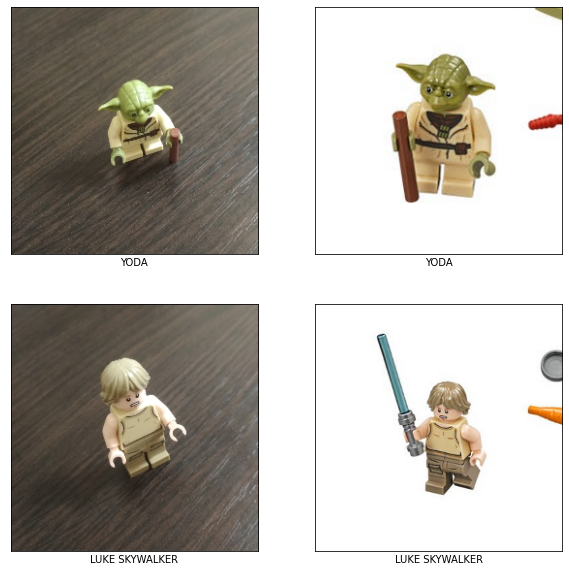

In [17]:
def show(batch, pred_labels=None):
    plt.figure(figsize=(10,10))
    for i in range(4):
        plt.subplot(2,2,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(batch[0][i], cmap=plt.cm.binary)
        # The CIFAR labels happen to be arrays, 
        # which is why you need the extra index
        lbl = names[int(batch[1][i])]
        if pred_labels is not None:
            lbl += "/ Pred:" + names[int(pred_labels[i])]
        plt.xlabel(lbl)
    plt.show()

show(test_batch)

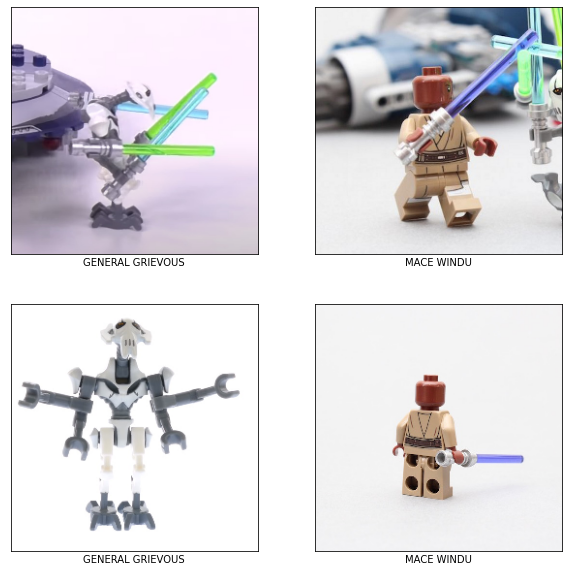

In [18]:
show(train_batch)

# Convolutional Model

In [19]:
model = keras.models.Sequential()
model.add(layers.Conv2D(32, (3,3), strides=(1,1), padding="valid", activation='relu', input_shape=(256, 256,3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5))
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 246016)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                15745088  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 3

In [21]:
# loss and optimizer
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optim = keras.optimizers.Adam(lr=0.001)
metrics = ["accuracy"]

model.compile(optimizer=optim, loss=loss, metrics=metrics)

In [22]:
# training
epochs = 30

# callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=2
)

history = model.fit(train_batches, validation_data=val_batches,
                    callbacks=[early_stopping],
                      epochs=epochs, verbose=2)

Epoch 1/30
10/10 - 7s - loss: 6.2484 - accuracy: 0.1892 - val_loss: 1.5804 - val_accuracy: 0.1875
Epoch 2/30
10/10 - 4s - loss: 1.5961 - accuracy: 0.1892 - val_loss: 1.5679 - val_accuracy: 0.2500
Epoch 3/30
10/10 - 4s - loss: 1.3209 - accuracy: 0.4865 - val_loss: 1.7250 - val_accuracy: 0.1875
Epoch 4/30
10/10 - 4s - loss: 1.1808 - accuracy: 0.5135 - val_loss: 1.5069 - val_accuracy: 0.3125
Epoch 5/30
10/10 - 5s - loss: 0.6969 - accuracy: 0.7027 - val_loss: 1.2626 - val_accuracy: 0.3750
Epoch 6/30
10/10 - 4s - loss: 0.2698 - accuracy: 0.9459 - val_loss: 1.5358 - val_accuracy: 0.5625
Epoch 7/30
10/10 - 5s - loss: 0.0595 - accuracy: 1.0000 - val_loss: 1.5084 - val_accuracy: 0.5000
Epoch 8/30
10/10 - 4s - loss: 0.0494 - accuracy: 1.0000 - val_loss: 1.1854 - val_accuracy: 0.6250
Epoch 9/30
10/10 - 4s - loss: 0.0193 - accuracy: 1.0000 - val_loss: 1.6955 - val_accuracy: 0.7500
Epoch 10/30
10/10 - 4s - loss: 0.0101 - accuracy: 1.0000 - val_loss: 2.4721 - val_accuracy: 0.5000
Epoch 11/30
10/10 -

In [23]:
model.save("D:/DataSets/LEGO_Minifigures/star-wars/lego_model.h5")

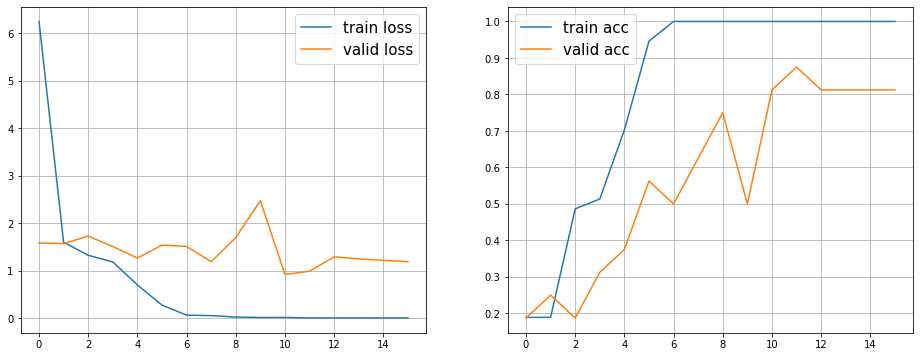

In [24]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.grid()
plt.legend(fontsize=15)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='valid acc')
plt.grid()
plt.legend(fontsize=15);

In [25]:
# evaluate on test data
model.evaluate(test_batches, verbose=2)

3/3 - 0s - loss: 0.5196 - accuracy: 0.7000


[0.5196386575698853, 0.699999988079071]

In [26]:
# make some predictions
predictions = model.predict(test_batches)
predictions = tf.nn.softmax(predictions)
labels = np.argmax(predictions, axis=1)

print(test_batches[0][1])
print(labels[0:4])

[0. 0. 1. 1.]
[0 3 1 3]


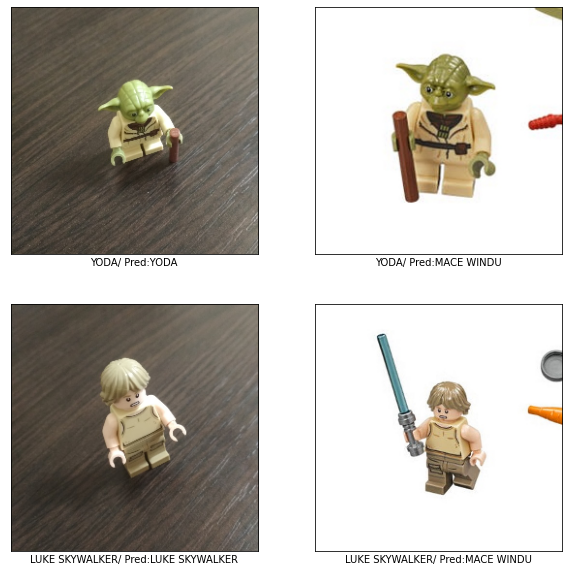

In [27]:
show(test_batches[0], labels[0:4])

# Transfer Learning 

In [28]:
vgg_model = tf.keras.applications.vgg16.VGG16()
print(type(vgg_model))
vgg_model.summary()

# try out different ones, e.g. MobileNetV2
#tl_model = tf.keras.applications.MobileNetV2()
#print(type(tl_model))
#tl_model.summary()

553467904/553467096 [==============================] - 61s 0us/step
<class 'tensorflow.python.keras.engine.functional.Functional'>
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584 

In [29]:
# convert to Sequential model, omit the last layer
# this works with VGG16 because the structure is linear
model = keras.models.Sequential()
for layer in vgg_model.layers[0:-1]:
    model.add(layer)

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [31]:
# set trainable=False for all layers
# we don't want to train them again
for layer in model.layers:
    layer.trainable = False
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [32]:
# add a last classification layer for our use case with 5 classes
model.add(layers.Dense(5))

In [33]:
# loss and optimizer
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optim = keras.optimizers.Adam(lr=0.001)
metrics = ["accuracy"]

model.compile(optimizer=optim, loss=loss, metrics=metrics)

In [34]:
# get the preprocessing function of this model
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [36]:
# Generate batches of tensor image data with real-time data augmentation.

train_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
valid_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

train_batches = train_gen.flow_from_directory(
    'D:/DataSets/LEGO_Minifigures/star-wars/train',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=4,
    shuffle=True,
    color_mode="rgb",
    classes=names   
)

val_batches = valid_gen.flow_from_directory(
    'D:/DataSets/LEGO_Minifigures/star-wars/val',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=4,
    shuffle=True,
    color_mode="rgb",
    classes=names
)

test_batches = test_gen.flow_from_directory(
    'D:/DataSets/LEGO_Minifigures/star-wars/test',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=4,
    shuffle=False,
    color_mode="rgb",
    classes=names
)

Found 37 images belonging to 5 classes.
Found 16 images belonging to 5 classes.
Found 10 images belonging to 5 classes.


In [37]:
epochs = 30

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=2
)

model.fit(train_batches, validation_data=val_batches,
          callbacks=[early_stopping],
          epochs=epochs, verbose=2)

Epoch 1/30
10/10 - 22s - loss: 2.8509 - accuracy: 0.2703 - val_loss: 1.0102 - val_accuracy: 0.6875
Epoch 2/30
10/10 - 25s - loss: 0.3085 - accuracy: 0.9459 - val_loss: 0.5419 - val_accuracy: 0.7500
Epoch 3/30
10/10 - 24s - loss: 0.0335 - accuracy: 1.0000 - val_loss: 0.3463 - val_accuracy: 0.8750
Epoch 4/30
10/10 - 23s - loss: 0.0138 - accuracy: 1.0000 - val_loss: 0.2836 - val_accuracy: 0.8750
Epoch 5/30
10/10 - 24s - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.2479 - val_accuracy: 0.8750
Epoch 6/30
10/10 - 23s - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.2355 - val_accuracy: 0.8750
Epoch 7/30
10/10 - 27s - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.2330 - val_accuracy: 0.8750
Epoch 8/30
10/10 - 26s - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.2402 - val_accuracy: 0.8750
Epoch 9/30
10/10 - 27s - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.2370 - val_accuracy: 0.8750
Epoch 10/30
10/10 - 27s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.2343 - val_accuracy: 0.8750
Epoch 11/

In [38]:
model.evaluate(test_batches, verbose=2)

3/3 - 5s - loss: 0.0234 - accuracy: 1.0000


[0.02335168421268463, 1.0]